# Brain Tumor Detection

A brain tumor is a mass or growth of abnormal cells in the brain. Brain tumors can be cancerous (malignant) or noncancerous (benign).

One of the tests to diagnose brain tumor is magnetic resonance imaging (MRI).

A brain MRI images dataset founded on Kaggle.

The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous (malignant) and the folder no contains 98 Brain MRI Images that are non-tumorous (benign).

In order to be fed into the Neural Network we have to pre-process the dataset images by performing Data Augmentation, Cropping the part of the image which has the brain in it and resizing all the images to have an uniform size.

### Data Augmentation

As we have a fairly small dataset we have to perform data augmentation in order to create more images to train the NN.

In [1]:
from keras.preprocessing.image import ImageDataGenerator,img_to_array
import cv2
import time
from os import listdir

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def augment_data(**args):
    """
    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: A string representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """
    datagen = ImageDataGenerator(rotation_range=10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.15,
                                 zoom_range=0.1,
                                 channel_shift_range = 10,
                                 horizontal_flip=True)
    
#  iterate over all the images in the folders
#  and perform augmentation
    directory = args.get('file_dir')
    generated_samples = args.get('n_generated_samples')
    save_to_dir = args.get('save_to_dir')
    
    for file in listdir(directory):
#       load the image
        print(file)
        read_path = directory + '\\' + file
        print(read_path)
        image = cv2.imread( read_path )
        image = img_to_array(image)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_'+file[:-4]
        i=0
        for batch in datagen.flow(x=image,
                                  batch_size=1,
                                  save_to_dir= save_to_dir,
                                  save_prefix=save_prefix,
                                  save_format='jpeg'):
            i+= 1
            if i > generated_samples:
                break
                

Remember that 61% of the data (155 images) are tumorous. And, 39% of the data (98 images) are non-tumorous.
So, in order to balance the data we can generate 9 new images for every image that belongs to 'no' class and 6 images for every image that belongs the 'yes' class.

In [3]:
start_time = time.time()
# Augment data for images with yes label
augment_data(file_dir = "Dataset\yes",
             n_generated_samples = 6,
             save_to_dir = r"Dataset\augmented_data\yes" )
end_time = time.time()

elapsed_time  = end_time - start_time
print('Elapsed time in seconds :{}'.format(elapsed_time))

Y1.jpg
Dataset\yes\Y1.jpg
Y10.jpg
Dataset\yes\Y10.jpg
Y100.JPG
Dataset\yes\Y100.JPG
Y101.jpg
Dataset\yes\Y101.jpg
Y102.jpg
Dataset\yes\Y102.jpg
Y103.jpg
Dataset\yes\Y103.jpg
Y104.jpg
Dataset\yes\Y104.jpg
Y105.jpg
Dataset\yes\Y105.jpg
Y106.jpg
Dataset\yes\Y106.jpg
Y107.jpg
Dataset\yes\Y107.jpg
Y108.jpg
Dataset\yes\Y108.jpg
Y109.JPG
Dataset\yes\Y109.JPG
Y11.jpg
Dataset\yes\Y11.jpg
Y111.JPG
Dataset\yes\Y111.JPG
Y112.JPG
Dataset\yes\Y112.JPG
Y113.JPG
Dataset\yes\Y113.JPG
Y114.JPG
Dataset\yes\Y114.JPG
Y115.JPG
Dataset\yes\Y115.JPG
Y116.JPG
Dataset\yes\Y116.JPG
Y117.JPG
Dataset\yes\Y117.JPG
Y12.jpg
Dataset\yes\Y12.jpg
Y120.JPG
Dataset\yes\Y120.JPG
Y13.jpg
Dataset\yes\Y13.jpg
Y14.jpg
Dataset\yes\Y14.jpg
Y146.JPG
Dataset\yes\Y146.JPG
Y147.JPG
Dataset\yes\Y147.JPG
Y148.JPG
Dataset\yes\Y148.JPG
Y15.jpg
Dataset\yes\Y15.jpg
Y153.jpg
Dataset\yes\Y153.jpg
Y154.jpg
Dataset\yes\Y154.jpg
Y155.JPG
Dataset\yes\Y155.JPG
Y156.JPG
Dataset\yes\Y156.JPG
Y157.JPG
Dataset\yes\Y157.JPG
Y158.JPG
Dataset\yes\Y158.

In [4]:
start_time = time.time()
augment_data(file_dir = r"Dataset\no",
             n_generated_samples = 9,
             save_to_dir = r"Dataset\augmented_data\no" )

end_time = time.time()

elapsed_time  = end_time - start_time
print('Elapsed time in seconds :{}'.format(elapsed_time))

1 no.jpeg
Dataset\no\1 no.jpeg
10 no.jpg
Dataset\no\10 no.jpg
11 no.jpg
Dataset\no\11 no.jpg
12 no.jpg
Dataset\no\12 no.jpg
13 no.jpg
Dataset\no\13 no.jpg
14 no.jpg
Dataset\no\14 no.jpg
15 no.jpg
Dataset\no\15 no.jpg
17 no.jpg
Dataset\no\17 no.jpg
18 no.jpg
Dataset\no\18 no.jpg
19 no.jpg
Dataset\no\19 no.jpg
2 no.jpeg
Dataset\no\2 no.jpeg
20 no.jpg
Dataset\no\20 no.jpg
21 no.jpg
Dataset\no\21 no.jpg
22 no.jpg
Dataset\no\22 no.jpg
23 no.jpg
Dataset\no\23 no.jpg
24 no.jpg
Dataset\no\24 no.jpg
25 no.jpg
Dataset\no\25 no.jpg
26 no.jpg
Dataset\no\26 no.jpg
27 no.jpg
Dataset\no\27 no.jpg
28 no.jpg
Dataset\no\28 no.jpg
29 no.jpg
Dataset\no\29 no.jpg
3 no.jpg
Dataset\no\3 no.jpg
30 no.jpg
Dataset\no\30 no.jpg
31 no.jpg
Dataset\no\31 no.jpg
32 no.jpg
Dataset\no\32 no.jpg
33 no.jpg
Dataset\no\33 no.jpg
34 no.jpg
Dataset\no\34 no.jpg
35 no.jpg
Dataset\no\35 no.jpg
36 no.jpg
Dataset\no\36 no.jpg
37 no.jpg
Dataset\no\37 no.jpg
38 no.jpg
Dataset\no\38 no.jpg
39 no.jpg
Dataset\no\39 no.jpg
4 no.jpg
D

In [7]:
# Data summary
def data_summary():
    total_yes_files = len(listdir(r"Dataset\augmented_data\yes"))
    total_no_files = len(listdir(r"Dataset\augmented_data\no"))
    
    total_files = total_yes_files + total_no_files
    percentage_yes = ( total_yes_files / total_files ) * 100
    percentage_no = ( total_no_files / total_files ) * 100
    
    print("Total Examples : {}".format(total_files))
    print('Percentage of yes examples : {:,.2f} %'.format(percentage_yes) )
    print('Percentage of no examples : {:,.2f} %'.format(percentage_no) )

In [8]:
data_summary()

Total Examples : 2064
Percentage of yes examples : 52.57 %
Percentage of no examples : 47.43 %


### Data Preprocessing

The point of interest for us in all the images is the brain itself, so we will use the crop the image by using the technique of finding extreme points using OpenCV .
[Finding Extreme Points with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)


In [16]:
import imutils
import cv2
import matplotlib.pyplot as plt

def crop_brain_contours(image, plot_image = False):
    # convert image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest
    # one
    cnts = cv2.findContours(thresh.copy(),
                            cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot_image:
        plt.figure()
        plt.subplot(1 , 2 ,1)
        plt.imshow(image)
#         plt.tick_params(axis='both', which='both', 
#                         top=False, bottom=False, left=False, right=False,
#                         labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1 , 2 ,2)
        plt.imshow(new_image)
#         plt.tick_params(axis='both', which='both', 
#                         top=False, bottom=False, left=False, right=False,
#                         labelbottom=False, labeltop=False, labelleft=False, labelright=False)
       
        plt.title('Cropped Image')
        
        plt.show()
    return new_image

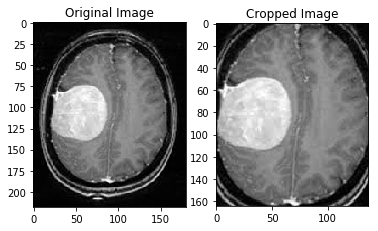

In [18]:
# test cropping 
test_image = cv2.imread(r'Dataset\yes\Y1.jpg')
test_image = crop_brain_contours( test_image ,True )

### Load the augmented images data

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:

    1) Read the image.
    2) Crop the part of the image representing only the
    brain.
    3) Resize the image (because the images in the dataset
    come in different sizes (meaning width, height and # of
    channels). So, we want all of our images to be (240, 240,
    3) to feed it as an input to the neural network.
    4) Apply normalization because we want pixel values to be
    scaled to the range 0-1.
    5) Append the image to X and its label to y.

After that, Shuffle X and y, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).
Finally, Return X and y.

In [22]:
import numpy as np
from sklearn.utils import shuffle

def prepare_images(directory_list , image_size):
    """
    directory_list : List of file directories
    image_size : Target size of the image, Height X Width
        
    """
    image_width ,image_height = image_size 
    X = []
    y =[]
    # Load all images in the directory
 
    for directory in directory_list:
        for file in listdir(directory):
            read_path = directory + '\\' + file
            image = cv2.imread(read_path)
            image = crop_brain_contours(image ,False)
            image = cv2.resize(image ,dsize = (image_width ,image_height),
                               interpolation = cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            
            X.append(image)
            # Create appropriate labels according to the folder
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X,y)
    return X,y
            
             

In [23]:
augmented_yes_path = r'Dataset\augmented_data\yes'
augmented_no_path = r'Dataset\augmented_data\no'

X , y = prepare_images([augmented_yes_path ,augmented_no_path],
                       (240,240))

print('Total number of example : {}'.format(len(X)))
print('Shape of X :{}'.format(X.shape) )
print('Shape of y :{}'.format(y.shape) )


Total number of example : 2064
Shape of X :(2064, 240, 240, 3)
Shape of y :(2064, 1)


### Plot processed images

In [31]:
def plot_sample_images(X, y , n=50):
    for label in [0,1]:
        images = X[np.argwhere(y==label)]
        images = images[:n]
        
        columns_needed = 10
        rows_needed = int( n / 10 )
        
        plt.figure(figsize=(20,10))
        
        i = 1
        for image in images:
            plt.subplot(rows_needed , columns_needed ,i)
            plt.imshow(image[0])
            i += 1
         
        label_string = lambda label : 'Yes' if label == 1 else 'No'
        plt.suptitle(f'Brain Tumor: {label_string(label)}')
        plt.show()
            

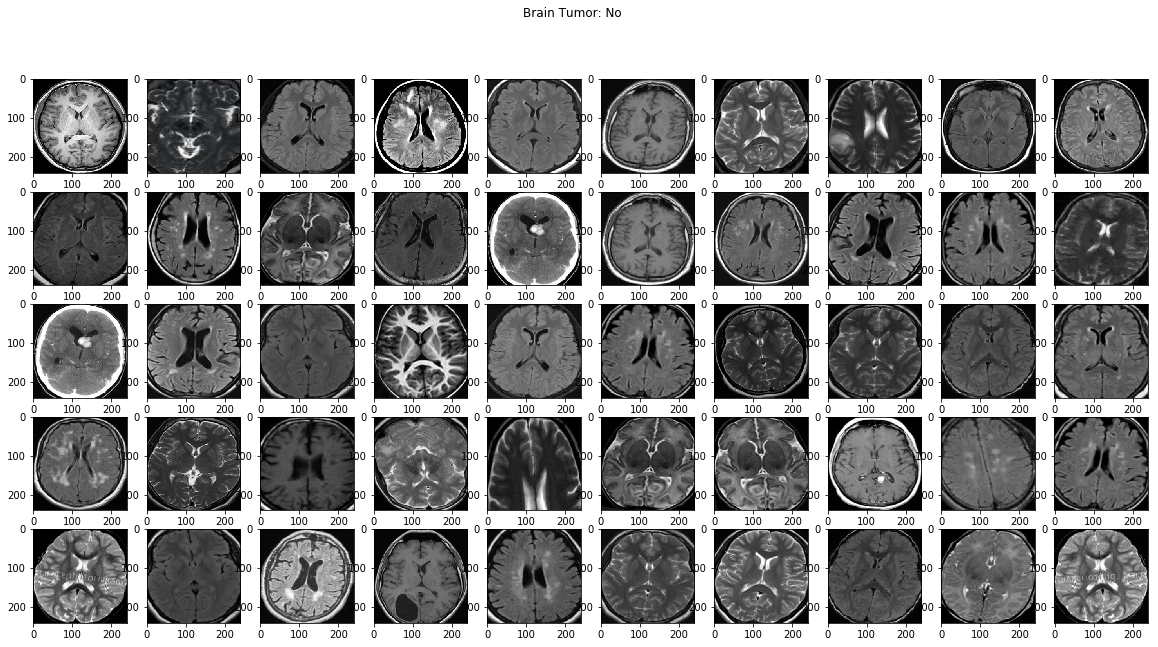

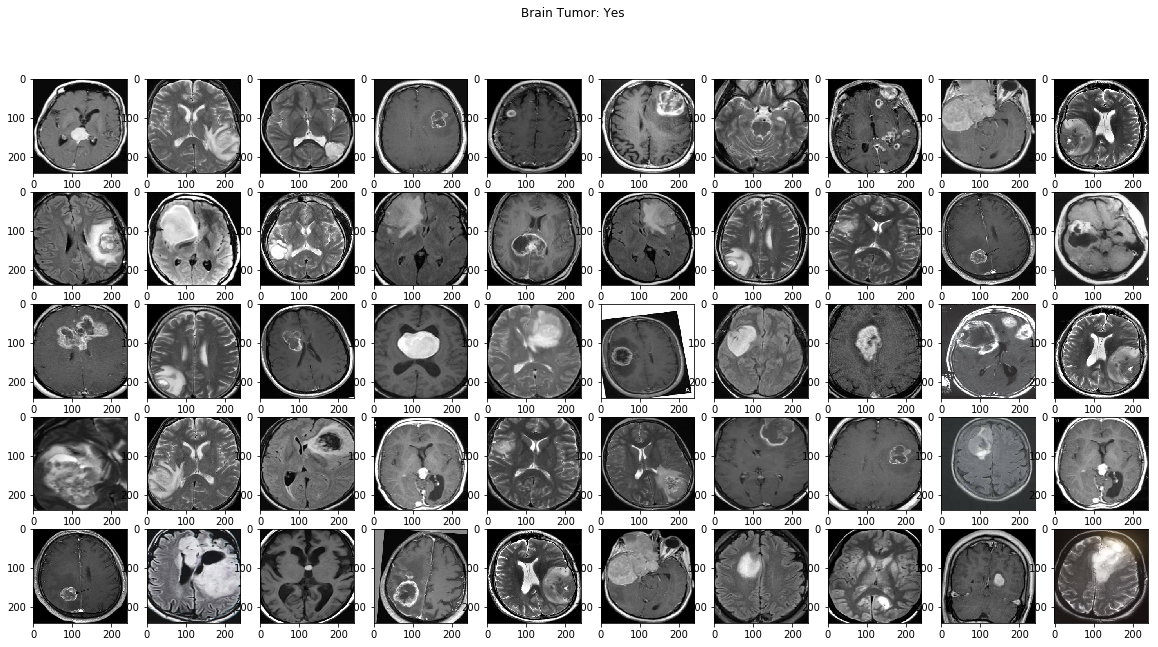

In [32]:
plot_sample_images(X,y)